# Examining feature corrrelations

In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import stats


def get_correlations_w_target(df, tar_var, input_vars):
    """
    Get correlations between a target variable and other
    variables in a dataframe.
    Inputs:
    df: dataframe
    tar_var: column name of the target variable
    input_vars: list of column names with which to find correlations with target
    """
    # create dataframe with basic stats
    corr = pd.DataFrame({
            k: {
                'pr': stats.pearsonr(df[k], df[tar_var])[0],
                'sr': stats.spearmanr(df[k], df[tar_var])[0],
                'variance': np.var(df[k]),
                'std': np.std(df[k]),
                'n_unique': len(np.unique(df[k])),
                'unique_frac': len(np.unique(df[k])) / len(df)
            } for k in input_vars
        }).T
    # get total correlation column
    corr['r_tot'] = np.sqrt(np.square(corr['pr']) + np.square(corr['sr']))
    corr['r2'] = np.square(corr['pr'])
    # sort values
    corr = corr.sort_values('r2', ascending=False)
    # add linear regression columns
    corr['slope'] = np.nan
    corr['intercept'] = np.nan
    for i, f in enumerate(corr.index):
        slope, intercept, _, _, _ = stats.linregress(df[f], df[tar_var])
        corr['slope'].iloc[i] = slope
        corr['intercept'].iloc[i] = intercept
    return corr


def plot_correlations(df, corr, nrows=5, ncols=5):
    """
    Plot correlatons between variables.
    Inputs:
    df: dataframe with feature columns
    corr: dataframe holding correlation information
    nrows, ncols = number of rrows and columns to use for plot grid
    """

    # plot scatter of pearson r vs spearnman r
    for i, f in enumerate(corr.index):

        # plot original features
        plt.scatter(
            corr['pr'].iloc[i], corr['sr'].iloc[i],
            s=15, c='k', vmin=0, vmax=1)
        plt.annotate(
            f, (corr['pr'].iloc[i], corr['sr'].iloc[i]),
            alpha=1, fontsize=10,)
    plt.axvline(x=0, c='k', alpha=0.2) 
    plt.axhline(y=0, c='k', alpha=0.2) 
    plt.xlabel("Pearson's r")
    plt.ylabel("Spearman's ρ")
    plt.title("Correlations between of each input feature and the target feature")
    plt.show()
    
    
    
    # create figure of correlations and linear fits
    ii = 0
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
    ax = np.ravel(ax)
    # loop over each feature
    for i, f in enumerate(corr.index):
        # filter by metric of choice for plotting
        if corr.loc[f, 'unique_frac'] < 0.1:
            continue

        color = 'c'
        if ii < len(ax): # if this feature should be plotted
            
            # show linear regression
            rsquared = np.square(corr['pr'].iloc[i])
            lin_fit = float(corr['slope'].iloc[i]) * df[f] + float(corr['intercept'].iloc[i])
            
            ax[ii].scatter(df[f], df[tar_var], s=15, c='k')
            ax[ii].plot(df[f], lin_fit, c='gray', lw=1)
            ax[ii].set_title('{} vs {}\nr-squared: {}'.format(
                tar_var,
                f.replace('MagpieData ', ''),
                round(rsquared, 4)), fontsize=18)
            ax[ii].set_yticks([])
            ax[ii].set_xticks([])
            ii += 1
    fig.set_size_inches(24, 16)
    plt.tight_layout()
    plt.show()


def get_input_correlations(df, input_vars):
    """
    Get r^2 correlations bettween diffeerent input features.
    Inputs:
    df: dataframe with features
    input_vars: list of column names to use as input features
    """
    # get all pairs of input feature combinations
    pairs = itertools.combinations(input_vars, 2)
    # loop over each pair of features and get r-squared correlation between them
    input_corrs = []
    for p in pairs:
        r2 = np.square(stats.pearsonr(df[p[0]], df[p[1]])[0])
        input_corrs.append([p[0], p[1], round(r2, 4)])
    input_corrs = pd.DataFrame(input_corrs, columns=['1', '2', 'r2']).sort_values(
        'r2', ascending=False, ignore_index=True)
    return input_corrs

# Example usage

In [2]:
df = pd.DataFrame(
    data=np.random.random((10, 10)),
    columns=["feature-{}".format(i+1) for i in range(10)],
)

df

,feature-1,feature-2,feature-3,feature-4,feature-5,feature-6,feature-7,feature-8,feature-9,feature-10
0,0.084674,0.015649,0.536103,0.194829,0.370828,0.869705,0.047048,0.556368,0.272873,0.333609
1,0.951009,0.499116,0.812762,0.736912,0.112726,0.405077,0.930101,0.797271,0.300549,0.901181
2,0.011513,0.249282,0.474811,0.123514,0.661107,0.996485,0.105469,0.153379,0.457472,0.550889
3,0.498936,0.904425,0.720920,0.531072,0.636203,0.336191,0.444093,0.872303,0.063790,0.424622
4,0.873472,0.680999,0.251851,0.868545,0.040888,0.475792,0.260738,0.770700,0.163601,0.436303
5,0.522802,0.085342,0.121667,0.864014,0.865840,0.514635,0.595669,0.947074,0.404288,0.585000
6,0.930403,0.542773,0.002752,0.906654,0.735887,0.468195,0.586823,0.488738,0.110791,0.534436
7,0.590239,0.277971,0.458409,0.705625,0.202616,0.977839,0.531325,0.275320,0.386863,0.319462
8,0.195145,0.690389,0.647030,0.164449,0.708118,0.294576,0.823067,0.493809,0.906047,0.784299
9,0.657746,0.903779,0.707100,0.254080,0.004575,0.197396,0.790825,0.633627,0.967174,0.904707


# Get correlations between each input feature and the target feature


This is a table showing statistics of each input feature's correlation with the target feature. The index is the name of the input feature. Columns:
1. pr: peasrson's r correlatioin coefficient
1. sr: spearman's r rank coefficient
1. variance: variance in the values of the feature
1. std: standard deviation inn the values of the feature
1. n_unique: number of unique values in the feature
1. unique_frac: fraction of values in the feature which are unique
1. r_tot: magnitude of combined "r" score sqrt((pearsons r)^2 + (spearmans r)^2)
1. r2: r-quarred value (pearson's r)^2
1. slope: slope of linear fit between feature and target variable
1. intercept: intercept of linear fit between feature and target variable

In [3]:
# set target variable name
tar_var = "feature-1"

# list of variable names to ignore (string variables, metadata, etc)
non_input_vars = []

# input variables are all other numeric features
input_vars = [v for v in list(df) if all([
    v not in non_input_vars,
    pd.api.types.is_numeric_dtype(df[v])])]

# get dataframe of correlations between target variable and each feature
corr = get_correlations_w_target(df, tar_var, input_vars)

corr

,pr,sr,variance,std,n_unique,unique_frac,r_tot,r2,slope,intercept
feature-1,1.000000,1.000000,0.105575,0.324924,10.0,1.0,1.414214,1.000000,1.000000,0.000000
feature-4,0.817425,0.806061,0.092879,0.304760,10.0,1.0,1.148006,0.668184,0.871508,0.065364
feature-7,0.509570,0.527273,0.081148,0.284864,10.0,1.0,0.733265,0.259662,0.581230,0.234286
feature-6,-0.470707,-0.357576,0.075421,0.274630,10.0,1.0,0.591122,0.221565,-0.556909,0.839893
feature-8,0.451340,0.284848,0.059423,0.243768,10.0,1.0,0.533710,0.203708,0.601601,0.171320
feature-5,-0.409491,-0.357576,0.094492,0.307395,10.0,1.0,0.543639,0.167683,-0.432842,0.719395
feature-2,0.396767,0.284848,0.091387,0.302303,10.0,1.0,0.488429,0.157424,0.426456,0.324775
feature-9,-0.314339,-0.272727,0.085977,0.293218,10.0,1.0,0.416160,0.098809,-0.348329,0.672091
feature-10,0.230433,0.260606,0.042659,0.206541,10.0,1.0,0.347872,0.053099,0.362510,0.322262
feature-3,-0.221286,-0.066667,0.065966,0.256839,10.0,1.0,0.231111,0.048968,-0.279946,0.664104


# Plot the correlations

The first figure shows Spearman's r and Pearson's r between each input feature and the target feature.

The second figure plots the target feature (y-axis) against each input feature (x-axis).

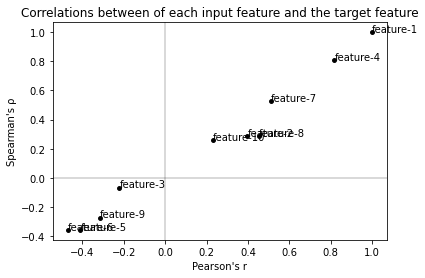

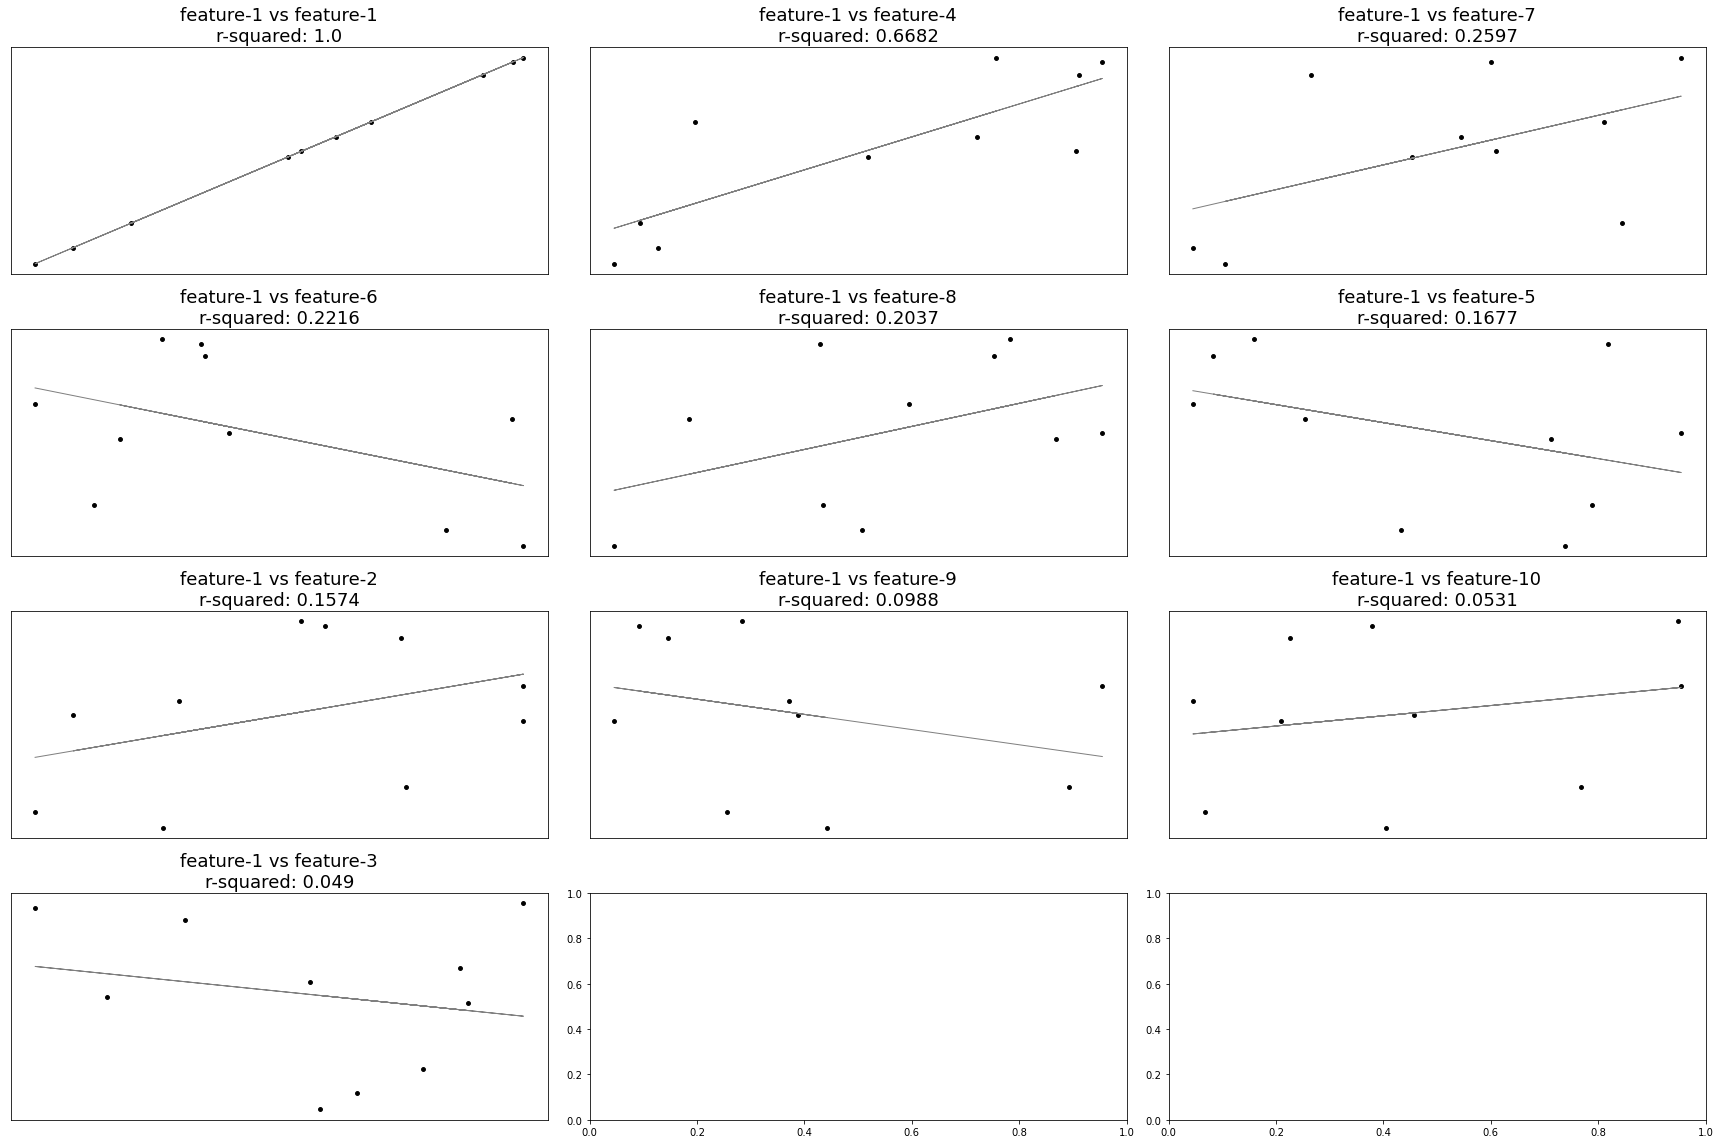

In [4]:
plot_correlations(df, corr, nrows=4, ncols=3)

# Examine redunant (colinear) features

In [5]:
# this returns a df sorted by highest to lowest correlations
input_corrs = get_input_correlations(df, input_vars)
input_corrs

,1,2,r2
0,feature-1,feature-4,0.6682
1,feature-2,feature-6,0.5959
2,feature-7,feature-10,0.5938
3,feature-6,feature-7,0.4697
4,feature-6,feature-8,0.4312
5,feature-6,feature-10,0.4230
6,feature-9,feature-10,0.4108
7,feature-4,feature-9,0.3560
8,feature-3,feature-4,0.3326
9,feature-1,feature-7,0.2597
